In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
from modules import Base, Streets, GreenAreas

In [2]:
st = Streets.Streets()
ga = GreenAreas.GreenAreas()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [68]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

nodes_df, edges_df = st.get_current_nodes_and_edges()
net = st.current_scenario['net']
ga_idxs = ga.get_green_areas_ids()
ga_nodes_set = []
# idx = ga_idxs[10]
for idx in ga_idxs:
    points = pd.DataFrame(ga.get_countour_by_id(idx), columns=['x', 'y', 'key'])
    ga_nodes_ids = net.get_node_ids(points['x'], points['y'])
    ga_nodes = nodes_df[nodes_df['osmid'].isin(ga_nodes_ids)]
    ga_nodes['ID_AV'] = idx
    ga_nodes_set.append(ga_nodes)

ga_nodes_set = pd.concat(ga_nodes_set)
ga_nodes_set.drop_duplicates('osmid', inplace=True)

# geom = ga.get_green_area_by_id(idx)
# geom.plot(color='green', alpha=0.1, ax=ax)

<Axes: >

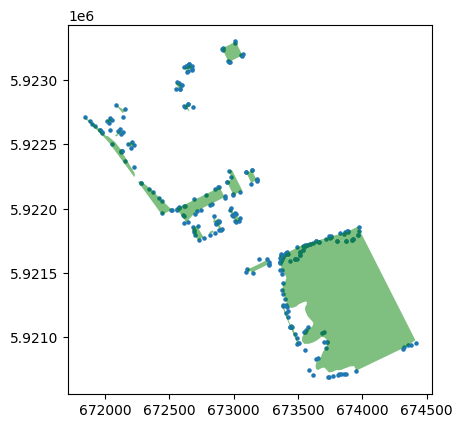

In [9]:
fig, ax = plt.subplots()
ga_nodes_set.plot(markersize=5, ax=ax)
ga.get_green_areas().plot(ax=ax,color='green', alpha=0.5)

In [49]:
select_unit = 'hex'
unit = gpd.read_file(f'/app/assets/groupby/{select_unit}')
unit['centroid'] = unit['geometry'].centroid
unit['node_ids'] = net.get_node_ids(unit['centroid'].x, unit['centroid'].y)

In [100]:
paths_output = []

for idx in range(len(unit)):
    source = unit.loc[idx, 'node_ids']
    source = [source]*len(ga_nodes_set)
    destination = ga_nodes_set['osmid']
    paths = net.shortest_path_lengths(source, ga_nodes_set['osmid'])
    paths_df = pd.DataFrame.from_dict({
        'source': source,
        'destination': destination,
        'path_lengths': paths
    })
    paths_df.sort_values(by=['path_lengths'], inplace=True)
    paths_df.reset_index(inplace=True, drop=True)
    paths_df = paths_df.head(1)
    paths_df['ID_AV'] = ga_nodes_set[ga_nodes_set['osmid'] == paths_df.loc[0,'destination']]['ID_AV'].values[0]
    paths_df['hex_id'] = unit.loc[idx, 'hex_id']
    paths_output.append(paths_df)

paths_output = pd.concat(paths_output)
paths_output.reset_index(inplace=True, drop=True)

In [104]:
paths_output = pd.merge(paths_output, unit, on='hex_id')

In [113]:
columns = ['source', 'destination', 'path_lengths', 'ID_AV', 'hex_id', 'geometry']
gdf_ga_paths = gpd.GeoDataFrame(data=paths_output.drop(columns=['geometry']), geometry=paths_output['geometry'])
gdf_ga_paths = gdf_ga_paths[columns]
def calcular_tiempo(distancia_metros):
    velocidad_kph = 4.5

    # Convertir la velocidad a metros por minuto
    velocidad_mpm = velocidad_kph * 1000 / 60
    
    # Calcular el tiempo en minutos
    tiempo = (distancia_metros / velocidad_mpm)
    
    return tiempo

gdf_ga_paths['travel_time'] = gdf_ga_paths['path_lengths'].apply(calcular_tiempo)

<Axes: >

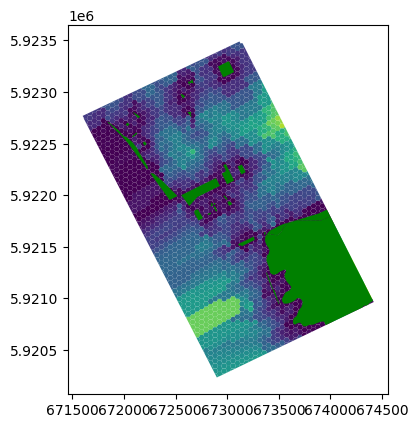

In [115]:
fig, ax = plt.subplots()
gdf_ga_paths.plot(column='travel_time', ax=ax)
ga.get_green_areas().plot(ax=ax, color='green')

In [116]:
gdf_ga_paths.to_file('/app/data/test_ga_travel')